# Laboratorio 10
## Proyecto de Consultoría — Predicción de Tripulación en Cruceros (PySpark)

- Sofia Mishell 22049
- Jose Marchena 22398

> **Contexto:** Hyundai Heavy Industries solicita un modelo para **estimar la tripulación** requerida en nuevos cruceros a partir de características físicas y operativas del barco.
> **Datos:** `barcos_crucero.csv` con variables: *Cruise_line* (categórica), *Age*, *Tonnage*, *passengers*, *length*, *cabins*, *passenger_density* y **crew** (objetivo, en centenas de personas).

---

### 0) Iniciar Spark

In [292]:
import os

## Para funcionamiento en windows
os.environ["SPARK_LOCAL_DIRS"] = r"C:\tmp\spark-temp"
# (Crear la carpeta en tu equipo si no existe)

In [293]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Cruceros_Spark").getOrCreate()
print("Spark version:", spark.version)

Spark version: 4.0.1


In [294]:
data_df = spark.read.csv("./barcos_crucero.csv", header=True, inferSchema=True)

In [295]:
data_df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [296]:
data_df.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       NULL|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     NULL|       NULL| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

---

## 1) Analisis Exploratorio

In [297]:
data_df.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

In [298]:
## Categoricas: Ship Name y Cruise_line
print(data_df.select("Ship_name").distinct().count())
print(data_df.select("Cruise_line").distinct().count())

138
20


Los nombres son casi todos unicos, de las 158 observaciones hay 138 nombres diferentes, lo que significa que solo 20 se repiten mas de una vez. Para la regresion se podria botar esta columna 

In [299]:
from pyspark.sql import functions as F
ship_common_names = data_df.groupBy("Ship_name").count().orderBy(F.desc("count")).limit(6)
ship_common_names.show()     

+---------+-----+
|Ship_name|count|
+---------+-----+
|   Spirit|    4|
|   Legend|    3|
|     Star|    3|
|    Pride|    2|
|     Dawn|    2|
|      Sun|    2|
+---------+-----+



In [300]:
cruise_lines_freq = data_df.groupBy("Cruise_line").count().orderBy(F.desc("count"))
cruise_lines_freq.show() 

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|  Royal_Caribbean|   23|
|         Carnival|   22|
|         Princess|   17|
| Holland_American|   14|
|        Norwegian|   13|
|            Costa|   11|
|        Celebrity|   10|
|              MSC|    8|
|              P&O|    6|
|             Star|    6|
|Regent_Seven_Seas|    5|
|        Silversea|    4|
|           Cunard|    3|
|         Seabourn|    3|
|         Windstar|    3|
|          Oceania|    3|
|          Crystal|    2|
|           Disney|    2|
|          Azamara|    2|
|           Orient|    1|
+-----------------+-----+



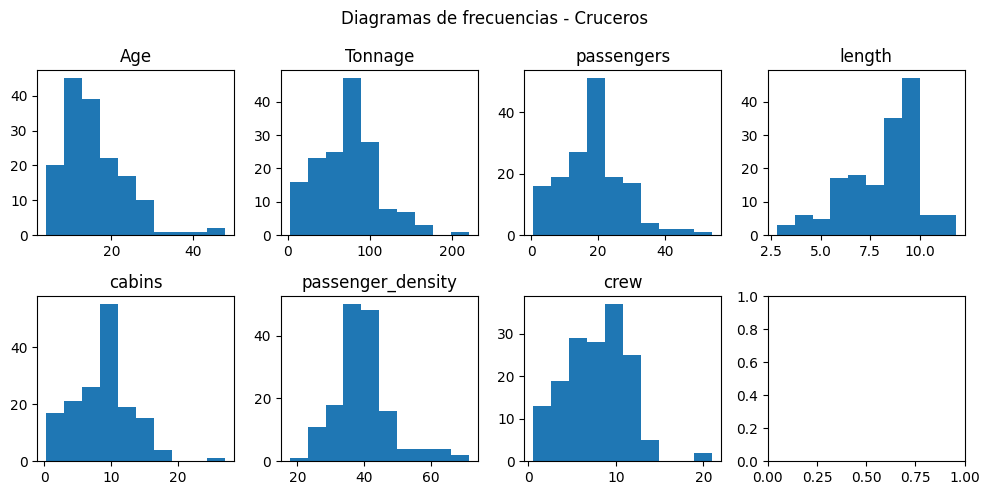

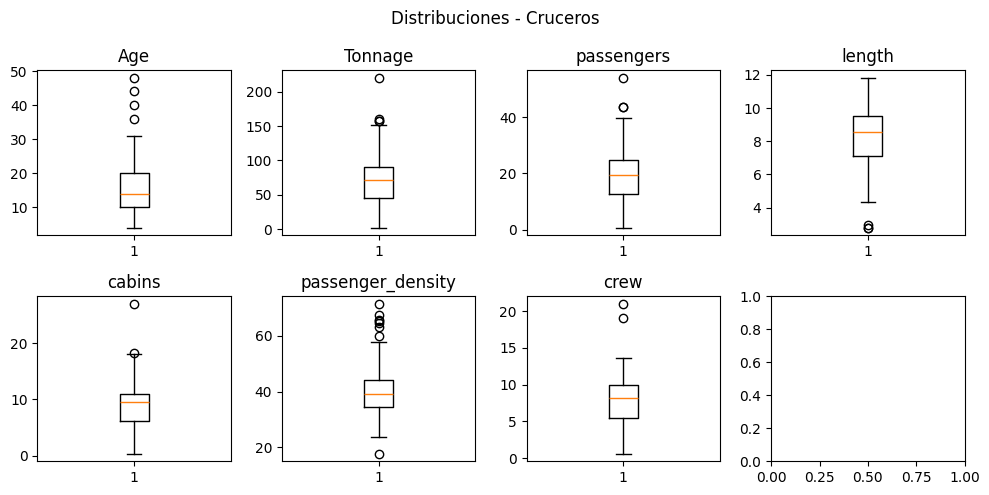

In [301]:
from matplotlib import pyplot as plt
import seaborn as sns

# Columnas numericas
cols =data_df.columns
cols.remove("Ship_name")
cols.remove("Cruise_line")

# Conversion a pandas
pandas_df = data_df.select(cols).toPandas()

# Histogramas
fig, ax = plt.subplots(2,4,figsize=(10,5))
fig.suptitle("Diagramas de frecuencias - Cruceros")
axes = ax.flatten()
for i, c in enumerate(cols):
    axes[i].set_title(f"{c}")
    axes[i].hist(pandas_df[c])
plt.tight_layout()
plt.show()

# Boxplots
fig, ax = plt.subplots(2,4,figsize=(10,5))
fig.suptitle("Distribuciones - Cruceros")
axes = ax.flatten()
for i, c in enumerate(cols):
    axes[i].set_title(f"{c}")
    axes[i].boxplot(pandas_df[c])
plt.tight_layout()
plt.show()

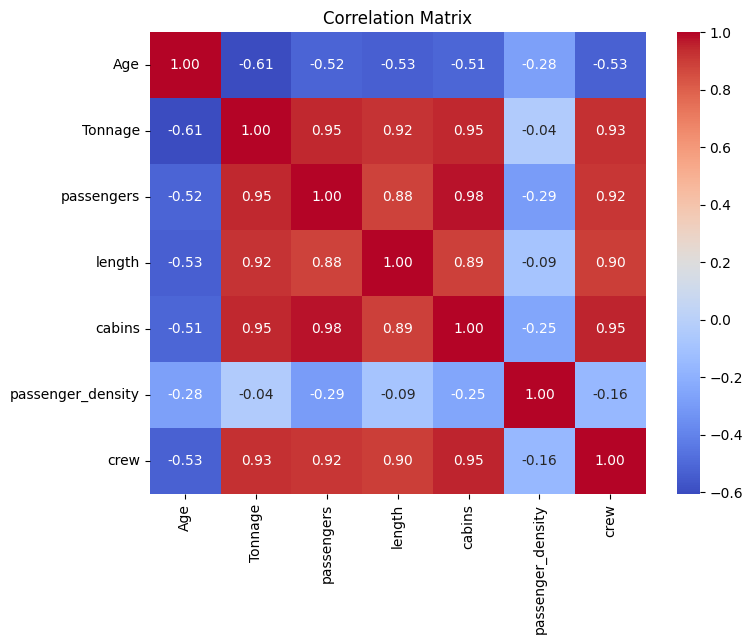

In [302]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

cols = data_df.columns
cols.remove("Ship_name")
cols.remove("Cruise_line")

pdf = data_df.select(cols).toPandas()
corr = pdf.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

---

## 2) Normalizacion

In [303]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

cat_cols = ['Ship_name', 'Cruise_line']
num_cols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins','passenger_density']

In [304]:
# 1 index categoricas
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
    for col in cat_cols
]
# 2 OneHotEncoder para categoricas
encoders = [
    OneHotEncoder(
        inputCols=[f"{col}_index"],
        outputCols=[f"{col}_encoded"]
    )
    for col in cat_cols
]
# 3 Standard scaler para numericas
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_scaled",
    withMean=True,
    withStd=True
)

## Pipleine
assembler = VectorAssembler(
    inputCols=[f"{col}_encoded" for col in cat_cols] + num_cols,
    outputCol="features_raw"
)
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

---

## 3) Reg Lineal

Target -> "Crew"

In [305]:
from pyspark.ml.regression import LinearRegression

train_df_raw, test_df_raw = data_df.randomSplit([0.7, 0.3], seed=67) # ~ six seven ~

pipeline_model = pipeline.fit(train_df_raw)
train_df = pipeline_model.transform(train_df_raw)
test_df= pipeline_model.transform(test_df_raw)

In [306]:
train_df

DataFrame[Ship_name: string, Cruise_line: string, Age: int, Tonnage: double, passengers: double, length: double, cabins: double, passenger_density: double, crew: double, Ship_name_index: double, Cruise_line_index: double, Ship_name_encoded: vector, Cruise_line_encoded: vector, features_raw: vector, features_scaled: vector]

In [307]:
test_df

DataFrame[Ship_name: string, Cruise_line: string, Age: int, Tonnage: double, passengers: double, length: double, cabins: double, passenger_density: double, crew: double, Ship_name_index: double, Cruise_line_index: double, Ship_name_encoded: vector, Cruise_line_encoded: vector, features_raw: vector, features_scaled: vector]

### Entrenar el modelo

In [308]:
# Crear modelo de regresión lineal
lr = LinearRegression(
    featuresCol="features_scaled",
    labelCol="crew",
    elasticNetParam=0.0,  # Ridge
    regParam=0.3
)

# Entrenar
lr_model = lr.fit(train_df)

# Predicciones
predictions = lr_model.transform(test_df)
predictions.select("crew", "prediction").show(10)


+-----+------------------+
| crew|        prediction|
+-----+------------------+
|11.85|11.525991128670118|
|  6.0| 6.671780638476041|
|  5.2| 5.404471386697731|
|  9.2| 8.986405693407173|
|  8.5| 8.385872581980173|
| 8.58|  7.52836774183498|
| 6.17| 5.942750106212897|
|  4.7| 6.071338209384011|
| 12.0|12.239807915960522|
|  9.0| 9.360447535805196|
+-----+------------------+
only showing top 10 rows


### Evaluar el modelo

In [309]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_r2 = RegressionEvaluator(
    labelCol="crew", predictionCol="prediction", metricName="r2"
)
evaluator_rmse = RegressionEvaluator(
    labelCol="crew", predictionCol="prediction", metricName="rmse"
)
evaluator_mae = RegressionEvaluator(
    labelCol="crew", predictionCol="prediction", metricName="mae"
)

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


R²: 0.9125
RMSE: 1.0299
MAE: 0.6997


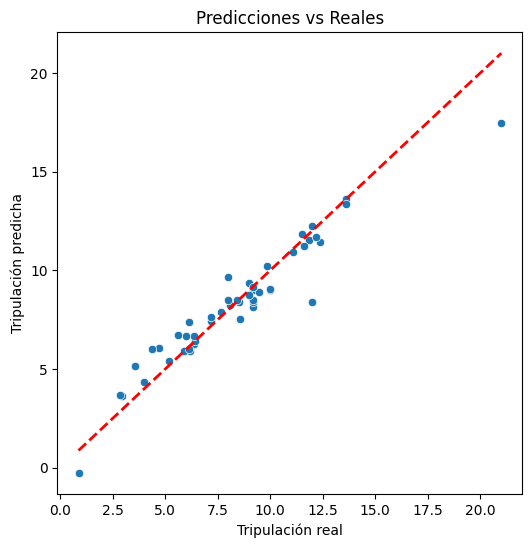

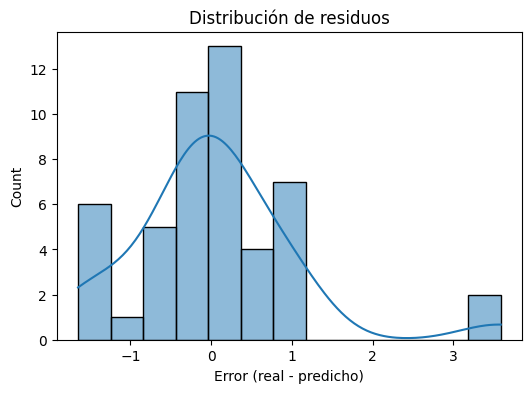

In [310]:
pred_pd = predictions.select("crew", "prediction").toPandas()

# Gráfico real vs predicho
plt.figure(figsize=(6,6))
sns.scatterplot(x="crew", y="prediction", data=pred_pd)
plt.plot([pred_pd.crew.min(), pred_pd.crew.max()],
         [pred_pd.crew.min(), pred_pd.crew.max()],
         'r--', lw=2)
plt.xlabel("Tripulación real")
plt.ylabel("Tripulación predicha")
plt.title("Predicciones vs Reales")
plt.show()

# Distribución de residuos
plt.figure(figsize=(6,4))
sns.histplot(pred_pd["crew"] - pred_pd["prediction"], kde=True)
plt.title("Distribución de residuos")
plt.xlabel("Error (real - predicho)")
plt.show()


### Interpretación del modelo inicial

* **Calidad del ajuste:** R²≈0.91 indica que el modelo explica ~**91%** de la variabilidad de `crew`.
* **Error:** RMSE≈1.03 y MAE≈0.70 (en **centenas** de tripulantes) → errores promedio ~**103** y **70** personas, respectivamente.
* **Signo de coeficientes (visión cualitativa):**

  * **Positivos:** *cabins*, *passengers*, *tonnage*, *length* → al crecer el tamaño/capacidad, crece la tripulación.
  * **Negativo:** *Age* → barcos más antiguos tienden a requerir relativamente más personal de mantenimiento.
  * **Dummies de *Cruise_line*:** capturan diferencias operativas entre líneas.
---


## 3) Optimización (tuning) de hiperparámetros

**Objetivo:** mitigar multicolinealidad, mejorar generalización y reducir error.
**Estrategia:** barrido de **regularización** con *Elastic Net* (combina L1+L2).


* **`regParam` (λ):** controla la magnitud de la penalización; valores más altos → coeficientes más pequeños (menos varianza, riesgo de subajuste).
* **`elasticNetParam` (α):** mezcla de penalizaciones:

  * **α=0.0 (Ridge/L2):** estabiliza coeficientes cuando hay multicolinealidad.
  * **α=1.0 (Lasso/L1):** puede **anular** coeficientes (selección de variables).
  * **α=0.5 (Elastic Net):** balancea estabilidad (L2) y parsimonia (L1).

In [311]:
for reg in [0.1, 0.3, 0.5, 0.7]:
    for alpha in [0.0, 0.5, 1.0]:   # 0 = Ridge, 1 = Lasso, 0.5 = Elastic Net
        lr = LinearRegression(featuresCol="features_scaled", labelCol="crew",
                              regParam=reg, elasticNetParam=alpha)
        model = lr.fit(train_df)
        r2 = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="r2").evaluate(model.transform(test_df))
        print(f"reg={reg}, alpha={alpha}, R²={r2:.4f}")


reg=0.1, alpha=0.0, R²=0.8987
reg=0.1, alpha=0.5, R²=0.9503
reg=0.1, alpha=1.0, R²=0.9468
reg=0.3, alpha=0.0, R²=0.9125
reg=0.3, alpha=0.5, R²=0.9412
reg=0.3, alpha=1.0, R²=0.9353
reg=0.5, alpha=0.0, R²=0.9101
reg=0.5, alpha=0.5, R²=0.9318
reg=0.5, alpha=1.0, R²=0.9218
reg=0.7, alpha=0.0, R²=0.9054
reg=0.7, alpha=0.5, R²=0.9210
reg=0.7, alpha=1.0, R²=0.9047


### Resultados del barrido (R² en test)

| regParam | α (elasticNetParam) | Tipo            |         R² |
| -------: | ------------------: | --------------- | ---------: |
|      0.1 |                 0.0 | Ridge           |     0.8987 |
|  **0.1** |             **0.5** | **Elastic Net** | **0.9503** |
|      0.1 |                 1.0 | Lasso           |     0.9468 |
|      0.3 |                 0.0 | Ridge           |     0.9125 |
|      0.3 |                 0.5 | Elastic Net     |     0.9412 |
|      0.3 |                 1.0 | Lasso           |     0.9353 |
|      0.5 |                 0.0 | Ridge           |     0.9101 |
|      0.5 |                 0.5 | Elastic Net     |     0.9318 |
|      0.5 |                 1.0 | Lasso           |     0.9218 |
|      0.7 |                 0.0 | Ridge           |     0.9054 |
|      0.7 |                 0.5 | Elastic Net     |     0.9210 |
|      0.7 |                 1.0 | Lasso           |     0.9047 |

**Lectura:**

* Penalización **moderada** (`regParam=0.1`) + mezcla **L1/L2** (`α=0.5`) dio el **mejor equilibrio** entre sesgo y varianza.
* Con `α=0.5`, el modelo controla multicolinealidad **sin** descartar en exceso predictores útiles (como sí podría ocurrir con Lasso puro).


In [312]:
# Crear modelo de regresión lineal
lr = LinearRegression(
    featuresCol="features_scaled",
    labelCol="crew",
    elasticNetParam=0.5,  # Ridge
    regParam=0.1
)

# Entrenar
lr_model = lr.fit(train_df)

# Predicciones
predictions = lr_model.transform(test_df)
predictions.select("crew", "prediction").show(10)

+-----+------------------+
| crew|        prediction|
+-----+------------------+
|11.85|11.868998103092443|
|  6.0| 6.569276869196921|
|  5.2| 5.600445669330788|
|  9.2| 9.503949046784376|
|  8.5| 8.499492486736475|
| 8.58| 8.036886915788687|
| 6.17| 6.067176306343802|
|  4.7|5.3917094767129905|
| 12.0|12.028691583889225|
|  9.0| 8.805780520498772|
+-----+------------------+
only showing top 10 rows


In [313]:
r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


R²: 0.9503
RMSE: 0.7763
MAE: 0.5156


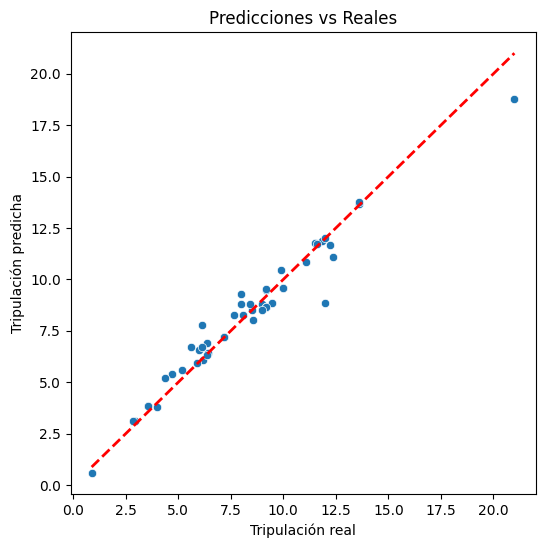

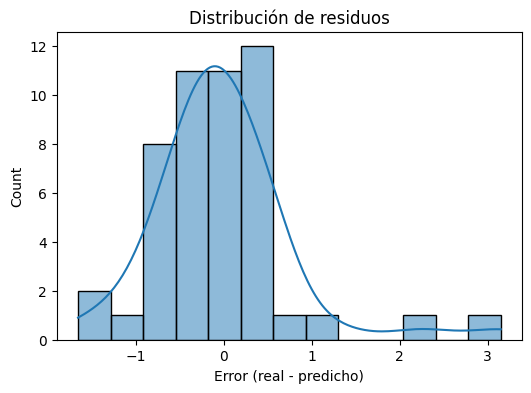

In [314]:
pred_pd = predictions.select("crew", "prediction").toPandas()

# Gráfico real vs predicho
plt.figure(figsize=(6,6))
sns.scatterplot(x="crew", y="prediction", data=pred_pd)
plt.plot([pred_pd.crew.min(), pred_pd.crew.max()],
         [pred_pd.crew.min(), pred_pd.crew.max()],
         'r--', lw=2)
plt.xlabel("Tripulación real")
plt.ylabel("Tripulación predicha")
plt.title("Predicciones vs Reales")
plt.show()

# Distribución de residuos
plt.figure(figsize=(6,4))
sns.histplot(pred_pd["crew"] - pred_pd["prediction"], kde=True)
plt.title("Distribución de residuos")
plt.xlabel("Error (real - predicho)")
plt.show()

### Comparación **antes vs después**

| Modelo                                |         R² |       RMSE |        MAE |
| ------------------------------------- | ---------: | ---------: | ---------: |
| **Inicial (Ridge, λ=0.3, α=0.0)**     |     0.9125 |     1.0299 |     0.6997 |
| **Final (Elastic Net, λ=0.1, α=0.5)** | **0.9503** | **0.7763** | **0.5156** |

**Mejoras:**

* **↑ R²:** +0.0378 (de 0.9125 a 0.9503). Si se compara el **error no explicado** (1−R²), se reduce de **0.0875** a **0.0497** → **−43%** de varianza no explicada.
* **↓ RMSE:** −0.2536 → **−24.6%** (de 1.0299 a 0.7763).
* **↓ MAE:** −0.1841 → **−26.3%** (de 0.6997 a 0.5156).

### ¿Por qué este es el mejor modelo?

* **Colinealidad controlada:** L2 estabiliza coeficientes entre *passengers*, *cabins* y *tonnage*.
* **Parcimonia sin pérdida de señal:** L1 atenúa/descarta ruido en dummies de *Cruise_line* y variables menos informativas, sin “vaciar” el modelo.
* **Generalización superior:** mejores métricas en test y residuos centrados en 0 (sin sesgo sistemático).
* **Coherencia con EDA:** variables clave coinciden con las correlaciones altas observadas; `Age` mantiene efecto negativo coherente.

---

## 5) Conclusiones para negocio

* El modelo final (Elastic Net) **explica ~95%** de la variabilidad del tamaño de la tripulación y reduce el error en ~**25%** respecto al modelo inicial.
* Las variables **más influyentes** son `cabins`, `passengers` y `tonnage`; `length` también aporta; `Age` presenta **efecto negativo**; `Cruise_line` ajusta diferencias operativas.
* **Usos recomendados:** estimaciones tempranas de tripulación en etapas de diseño, planeación de costos y dotación de personal.
---

> **Resultado final:** Modelo **Elastic Net (λ=0.1, α=0.5)** en PySpark con **R²=0.9503, RMSE=0.7763, MAE=0.5156**. Desempeño robusto, interpretable y alineado con los patrones del EDA.
